In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def blocking_cv(x,temperatura, n = 100000):
    x = np.array(x)
    n0 = int(len(x)/n)
    cvs = np.zeros(n0)
    for idx in range(n0):
        e0 = x[idx*n:(idx+1)*n]
        e0sq = np.power(e0,2)
        cvs[idx] = (np.mean(e0sq)-np.mean(e0)**2)/(temperatura*temperatura)
    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def bootstrap_cv(x, temperatura, n=100):
    x = np.array(x)
    cvs = np.zeros(n)
    for iteration in range(n):
        x_resampled = np.random.choice(x,len(x))
        cvs[iteration] = (np.mean(np.power(x_resampled,2))-np.mean(x_resampled)**2)/(temperatura**2)

    return (np.mean(cvs),np.sqrt(np.mean(np.power(cvs,2))-np.mean(cvs)**2))

def process_data(fileRoot,numFiles,nSpins):
    procesos_dfs = []
    for idx in range(numFiles):
        procesos_dfs.append(pd.read_csv(fileRoot+str(idx)+".csv",delimiter="\t"))
    dfs = pd.concat(procesos_dfs, join="inner")
    temp_list = sorted(list(dfs["Temperatura"].value_counts().index))
    e_timeseries = []
    m_timeseries = []
    for t in temp_list:
        e_timeseries.append(np.array(dfs[dfs["Temperatura"] == t]["Energia"].to_list()))
        m_timeseries.append(np.array(dfs[dfs["Temperatura"] == t]["Magnetizacion"].to_list()))
    e_mean = np.zeros(len(temp_list))
    m_mean = np.zeros(len(temp_list))
    cv_mean = np.zeros(len(temp_list))
    cv_mean_err = np.zeros(len(temp_list))

    for idx, t in enumerate(temp_list):
        e = e_timeseries[idx]
        m = m_timeseries[idx]
        e0 = np.mean(e)
        e_mean[idx] = (np.mean(e)/(nSpins))
        m_mean[idx] = (np.mean(m)/(nSpins))
        cv_mean[idx],cv_mean_err[idx] = blocking_cv(e,t,10000)
        print("T =",t, end='\r', flush=True)
    return (e_mean,m_mean,cv_mean,cv_mean_err,temp_list)

In [82]:
e4,m4,cv4,cverr4, t4= process_data("../PT-Data/DatosProceso",6,24*4)
e9,m9,cv9,cverr9, t9 = process_data("../PT-Data/DatosProcesoN9",6,24*9)
e15,m15,cv15,cverr15, t15 = process_data("../PT-Data/DatosProcesoN15",6,24*15)

<ErrorbarContainer object of 3 artists>

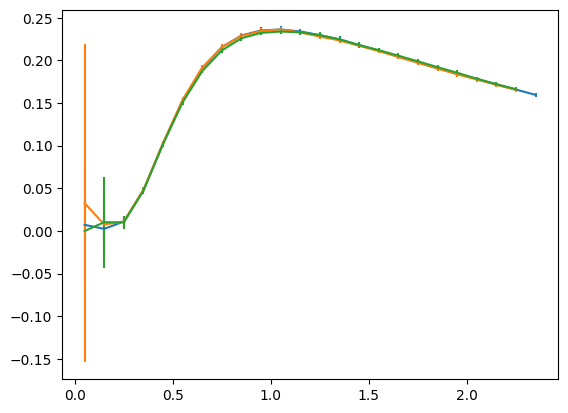

In [83]:
plt.errorbar(np.array(t15),cv15/(24*15),cverr15/(24*15))
plt.errorbar(np.array(t9),cv9/(24*9),cverr9/(24*9))
plt.errorbar(np.array(t4),cv4/(24*4),cverr4/(24*4))